In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Approach 1

In [2]:
# Necessary Imports
import torch
import cv2
from torch import nn
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
import json
import time
import logging
from typing import Dict, Optional
import numpy as np
from torchvision import models

In [3]:
# Setting the base directory
base_dir = os.path.join('..', 'input', 'eye-q')
train_df = pd.read_csv(os.path.join(base_dir, 'trainLabels.csv/trainLabels.csv'))

data = train_df['image']
labels = train_df['level']

Train Data: (26512,), Labels: (26512,)
 Validation Data: (2946,), Labels: (2946,)


<Axes: >

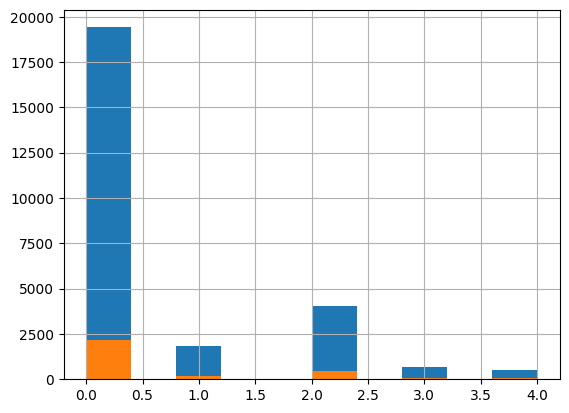

In [4]:
# Splitting the data in train and val using stratify to maintain class distribution
trainData, valData, trainLabels, valLabels = train_test_split(data, labels, test_size = 0.1, random_state = 69, stratify = labels)
print(f'Train Data: {trainData.shape}, Labels: {trainLabels.shape}\n Validation Data: {valData.shape}, Labels: {valLabels.shape}')
trainLabels.hist()
valLabels.hist()

In [5]:
def oversample_data(class_len, images_df, labels_df):
    combined_df = pd.concat([images_df, labels_df], axis=1)

    df = combined_df.groupby(['level']).apply(lambda x: x.sample(class_len, replace=True)).reset_index(drop=True)
    oversampled_images = df.iloc[:, :-1]  
    oversampled_labels = df.iloc[:, -1]   

    return oversampled_images, oversampled_labels

In [6]:
class_len = trainLabels.value_counts().max() // 2
class_len

9708

In [7]:
# Here the minority classes are oversampled and majority undersampled to halfway
trainData, trainLabels = oversample_data(class_len, trainData, trainLabels)
trainLabels.hist()
trainLabels = trainLabels.to_frame(name='level')

/tmp/ipykernel_30/3926731026.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = combined_df.groupby(['level']).apply(lambda x: x.sample(class_len, replace=True)).reset_index(drop=True)


In [8]:
trainData, trainLabels = trainData.iloc[:, 0], trainLabels.iloc[:, 0]

In [9]:
plt.figure(figsize = (25, 15))
for i in range(9):
    img_path = base_dir + '/train/train/' + trainData[i] + '.jpeg'
    img = Image.open(img_path)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Label: {trainLabels[i]}')
plt.show()

In [10]:
# Preprocessing step to identify circles
import numpy as np
def crop_color_image(img, tolerance=7):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img > tolerance
        
    # Check if there's enough intensity to crop
    if img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0] == 0:
        return img  # Return original if cropping would remove all pixels

    # Crop each channel separately and stack them
    cropped_channels = [img[:, :, i][np.ix_(mask.any(1), mask.any(0))] for i in range(3)]
    return np.stack(cropped_channels, axis=-1)

In [11]:
# Using a blurred weighted mask to highlight the image
def preprocess(path, sigma = 10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_color_image(image)
    image = cv2.resize(image, (300, 300))
    image=cv2.addWeighted (image, 4, cv2.GaussianBlur(image, (0,0), sigma), -4, 128)  
    return image

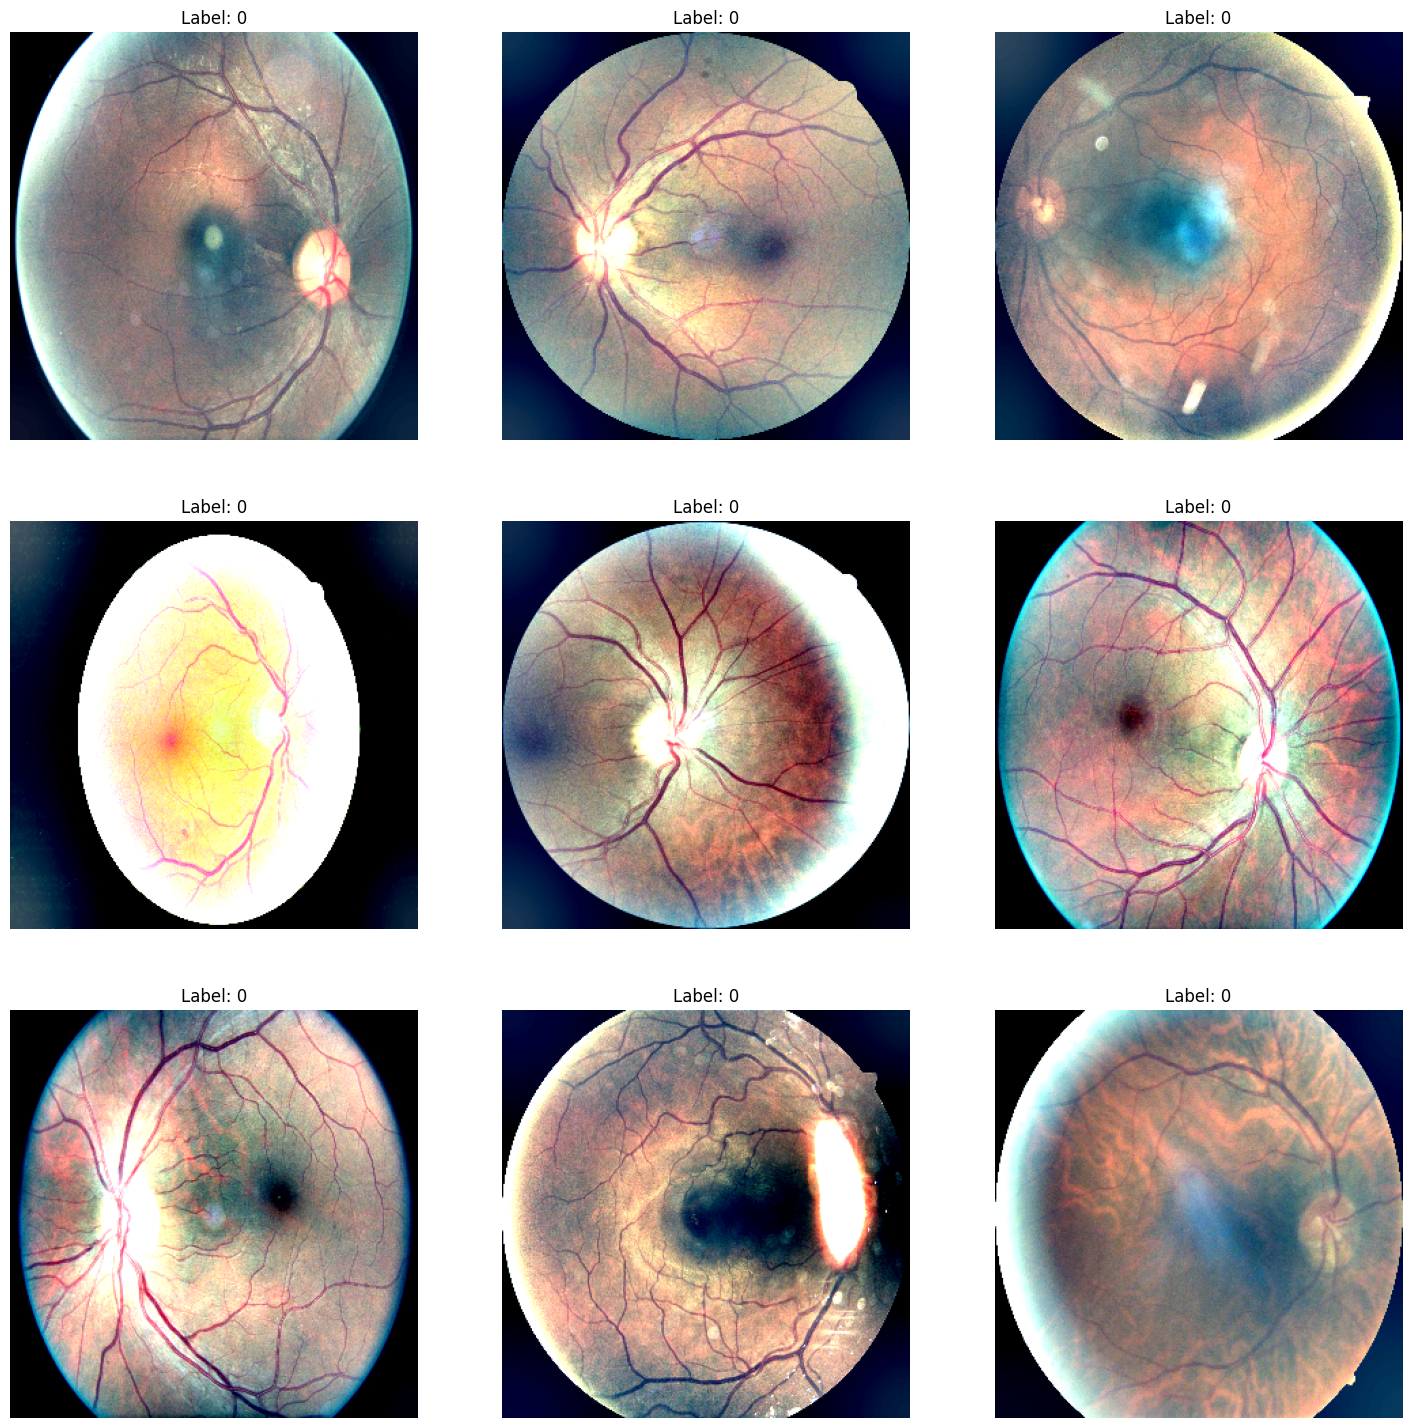

In [12]:
plt.figure(figsize = (18, 18))
for i in range(9):
    img_path = base_dir + '/train/train/' + str(trainData[i]) + '.jpeg'
    img = preprocess(img_path, 50)
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Label: {trainLabels[i]}')
plt.show()

In [13]:
# Splitting data into three parts which can be run simultaneously so as to improve performance
trainData1, trainData2, trainLabels1, trainLabels2 = train_test_split(trainData, trainLabels, stratify = trainLabels, 
                                                                      random_state = 69, test_size = 0.33)
trainData1, trainData3, trainLabels1, trainLabels3 = train_test_split(trainData1, trainLabels1, stratify = trainLabels1,
                                                                     random_state = 69, test_size = 0.5)
trainData1= trainData1.reset_index(drop = True)
trainData2= trainData1.reset_index(drop = True)
trainData3= trainData3.reset_index(drop = True)

trainLabels1 = trainLabels1.reset_index(drop = True)
trainLabels2 = trainLabels2.reset_index(drop = True)
trainLabels3 = trainLabels3.reset_index(drop = True)

trainData1.head(), trainLabels1.head()

(0     21469_left
 1     23786_left
 2    34761_right
 3    35955_right
 4       983_left
 Name: image, dtype: object,
 0    2
 1    1
 2    1
 3    4
 4    0
 Name: level, dtype: int64)

In [14]:
plt.figure(figsize = (25, 10))
plt.subplot(1, 3, 1)
trainLabels1.hist()

plt.subplot(1, 3, 2)
trainLabels2.hist()

plt.subplot(1, 3, 3)
trainLabels3.hist()

plt.show()

In [15]:
# Creating custom dataset to load images and return image and labels
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
from torchvision.io import read_image

class RetinalDataset(Dataset):
    def __init__(self, image_series, label_series, transform=None):
        self.image_paths = image_series
        self.labels = label_series
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image from file path
        image_path = base_dir + '/train/train/' + str(self.image_paths[idx]) + '.jpeg'
        
        # Preprocess image
        image = read_image(image_path)
        if self.transform:
            image = self.transform(image)
        
        # Retrieve corresponding label
        label = self.labels[idx]  # Accessing the label from the Series
        
        return image, label

In [16]:
from torchvision.transforms import v2
train_transforms = T.Compose([
    T.Resize((299, 299)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize((299, 299)),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
train_dataset = RetinalDataset(
    trainData1,
    trainLabels1,
    transform=train_transforms
)

val_dataset = RetinalDataset(
    valData,
    valLabels,
    transform=val_transforms
)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [19]:
image, label = next(iter(train_loader))
plt.imshow(image[0].permute(1, 2, 0))

In [20]:
# Using a transfer learning model InceptionNetV3
class InceptionClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        # Load pretrained InceptionV3 and immediately move to GPU
        self.inception = models.inception_v3(pretrained = True)
        
        for param in self.inception.parameters():
            param.requires_grad = False
            
        num_features = self.inception.fc.in_features
        self.inception.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        # Ensure input is on GPU
        return self.inception(x)

In [21]:
# Checkpointing to save the best model
class ModelTrainer:
    def __init__(self, model, criterion, optimizer, scheduler=None, device = 'cuda'):  # Force CUDA device
        self.model = model.to(device)
        
        # Ensure criterion is on GPU
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        # Verify model is on GPU
        print(f"Model is on CUDA: {next(model.parameters()).is_cuda}")
        
    def save_checkpoint(self, epoch, valid_loss, checkpoint_dir='checkpoints'):
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
            
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': valid_loss
        }
        
        if self.scheduler:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()
            
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        torch.save(checkpoint, checkpoint_path)
        
    def load_checkpoint(self, checkpoint_path):
        # Load checkpoint to GPU
        checkpoint = torch.load(checkpoint_path, map_location=device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        if self.scheduler and 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            
        return checkpoint['epoch'], checkpoint['loss']
    
    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0

        try:
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device, non_blocking=True)  # Ensure inputs are on GPU
                labels = labels.to(device, non_blocking=True)   # Ensure labels are on GPU

                self.optimizer.zero_grad()
                outputs = self.model(inputs)  # Outputs should now be calculated correctly

                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                
        except OSError as e:
             print(f"OSError {e} in Batch, Skipping Batch")

        return total_loss / len(train_loader)

    def validate(self, valid_loader):
        self.model.eval()
        total_loss = 0

        with torch.inference_mode():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device, non_blocking=True)  # Ensure inputs are on GPU
                labels = labels.to(device, non_blocking=True)   # Ensure labels are on GPU

                outputs = self.model(inputs)

                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                
        return total_loss / len(valid_loader)

In [22]:
'''model = InceptionClassifier(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

model = model.to(device)
trainer = ModelTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler
)

train_loss_list = []
valid_loss_list = []

num_epochs = 10
for epoch in tqdm(range(num_epochs)):
    train_loss = trainer.train_epoch(train_loader)
    train_loss_list.append(train_loss)
    valid_loss = trainer.validate(val_loader)
    valid_loss_list.append(valid_loss)
        
    scheduler.step(valid_loss)
    
    trainer.save_checkpoint(epoch, valid_loss)
        
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Valid Loss: {valid_loss:.4f}')'''

"model = InceptionClassifier(num_classes=5)\ncriterion = nn.CrossEntropyLoss()\noptimizer = torch.optim.Adam(model.parameters(), lr=0.001)\nscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)\n\nmodel = model.to(device)\ntrainer = ModelTrainer(\n    model=model,\n    criterion=criterion,\n    optimizer=optimizer,\n    scheduler=scheduler\n)\n\ntrain_loss_list = []\nvalid_loss_list = []\n\nnum_epochs = 10\nfor epoch in tqdm(range(num_epochs)):\n    train_loss = trainer.train_epoch(train_loader)\n    train_loss_list.append(train_loss)\n    valid_loss = trainer.validate(val_loader)\n    valid_loss_list.append(valid_loss)\n        \n    scheduler.step(valid_loss)\n    \n    trainer.save_checkpoint(epoch, valid_loss)\n        \n    print(f'Epoch {epoch+1}/{num_epochs}')\n    print(f'Train Loss: {train_loss:.4f}')\n    print(f'Valid Loss: {valid_loss:.4f}')"

This approach unfortunately even though it had really well preprocessed images, due to performance bottleneck slowed down training until the kaggle notebook had crashed. After unsuccessfully trying it twice, I went for the second method, which was more straightforward and yet efficient

# Approach 2

In [26]:
# Import required libraries
import pandas as pd
from fastai.vision.all import *
import torchvision.models as models
import seaborn as sns

In [27]:
# Load and prepare training data
csv_path = '/kaggle/input/eye-q/trainLabels.csv/trainLabels.csv'
df = pd.read_csv(csv_path)
image_folder = '../input/eye-q/train/train/'
df['image_path'] = image_folder + df['image'] + '.jpeg'

In [28]:
# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='level', palette='viridis')
plt.title('Distribution of Diabetic Retinopathy Levels')
plt.xlabel('DR Level')
plt.ylabel('Count')
plt.show()

# Data quality checks
missing_values = df.isnull().sum()
stats = df['level'].describe()
print("Missing Values per Column:\n", missing_values)
print("\nStatistical Summary for 'Level':\n", stats)

Missing Values per Column:
 image         0
level         0
image_path    0
dtype: int64

Statistical Summary for 'Level':
 count    29458.000000
mean         0.531570
std          0.973895
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: level, dtype: float64


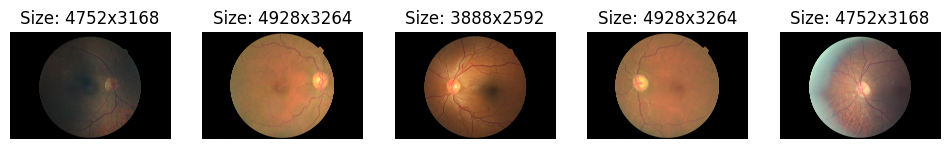

In [29]:
# Display sample images for visual inspection
sample_folder = '../input/eye-q/sample/sample'
sample_images = [img for img in os.listdir(sample_folder) if img.endswith('.jpeg')]

plt.figure(figsize=(12, 8))
for i, img_name in enumerate(sample_images[:5]):
    img_path = os.path.join(sample_folder, img_name)
    img = Image.open(img_path)
    width, height = img.size
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Size: {width}x{height}')
    plt.axis('off')
plt.show()

In [30]:
train_df = df
df.head()

image  level                                image_path
0   10_left      0   ../input/eye-q/train/train/10_left.jpeg
1  10_right      0  ../input/eye-q/train/train/10_right.jpeg
2   13_left      0   ../input/eye-q/train/train/13_left.jpeg
3  13_right      0  ../input/eye-q/train/train/13_right.jpeg
4   15_left      1   ../input/eye-q/train/train/15_left.jpeg

In [33]:
# Model setup and training
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('image_path'),
    get_y=ColReader('level'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(299),
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=10.0)
)

# Create DataLoader
dls = data_block.dataloaders(train_df, bs=32)

# Initialize pre-trained InceptionV3 model
inception_model = models.inception_v3(pretrained=True, aux_logits=True)
inception_model.aux_logits = None  # Disable auxiliary outputs
inception_model.fc = nn.Linear(inception_model.fc.in_features, dls.c)

# Create and save learner
learn = Learner(dls, inception_model, metrics=error_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 167MB/s]  


In [34]:
learn.load('model-1')

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

In [35]:
# Test data preparation
test_image_dir = "/kaggle/input/eye-q/test/test"
image_paths = []
for root, dirs, files in os.walk(test_image_dir):
    for file in files:
        if file.endswith(".jpeg"):
            image_paths.append(os.path.join(root, file))

test_df = pd.DataFrame({
    'image_path': image_paths
})
print(test_df.head())
len(test_df)

                                       image_path
0  /kaggle/input/eye-q/test/test/38111_right.jpeg
1  /kaggle/input/eye-q/test/test/40447_right.jpeg
2   /kaggle/input/eye-q/test/test/39457_left.jpeg
3  /kaggle/input/eye-q/test/test/43894_right.jpeg
4   /kaggle/input/eye-q/test/test/38477_left.jpeg


5668

In [37]:
# Generate predictions
test_dl = dls.test_dl(test_df['image_path'])
test_preds, _ = learn.get_preds(dl=test_dl)
print(test_preds[:20])

tensor([[9.2640e-01, 4.0104e-02, 3.2835e-02, 4.0399e-04, 2.6140e-04],
        [8.5169e-01, 2.5925e-02, 9.6802e-02, 4.6602e-03, 2.0919e-02],
        [1.5957e-06, 1.2189e-02, 9.1133e-01, 7.4492e-02, 1.9828e-03],
        [8.0827e-02, 2.6708e-01, 6.3778e-01, 1.3177e-02, 1.1340e-03],
        [8.5454e-01, 7.9126e-02, 6.5538e-02, 6.4756e-04, 1.4536e-04],
        [9.1562e-01, 5.6739e-02, 2.7338e-02, 2.5168e-04, 5.1611e-05],
        [6.2729e-01, 2.5176e-01, 1.2033e-01, 5.9430e-04, 2.6909e-05],
        [9.0975e-01, 6.4267e-02, 2.5802e-02, 1.6856e-04, 1.7114e-05],
        [9.4057e-01, 4.7542e-02, 1.1829e-02, 5.0079e-05, 6.3906e-06],
        [1.0618e-02, 1.0367e-01, 8.3057e-01, 4.9595e-02, 5.5485e-03],
        [9.5144e-01, 3.8282e-02, 1.0237e-02, 3.4052e-05, 6.1089e-06],
        [9.3825e-01, 4.6938e-02, 1.4736e-02, 6.6199e-05, 8.6960e-06],
        [9.1189e-01, 6.2696e-02, 2.5263e-02, 1.3894e-04, 1.5982e-05],
        [9.4604e-01, 4.4952e-02, 8.9795e-03, 2.7241e-05, 2.1601e-06],
        [9.3852e-01,

In [38]:
# Process predictions
predicted_classes = torch.argmax(test_preds, dim=1)
pred_labels = predicted_classes.numpy()

In [39]:
# Create submission file
image_names = test_df['image_path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
results_df = pd.DataFrame({
    'image': image_names,
    'level': pred_labels
})
results_df.to_csv("submission.csv", index=False)
print(results_df.head())

         image  level
0  38111_right      0
1  40447_right      0
2   39457_left      2
3  43894_right      2
4   38477_left      0


In [40]:
# Add visualization section
plt.figure(figsize=(12, 8))

# 1. Prediction Distribution
plt.subplot(2, 2, 1)
sns.countplot(data=results_df, x='level', palette='viridis')
plt.title('Distribution of Predicted DR Levels')
plt.xlabel('Predicted DR Level')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

In [41]:
# 2. Prediction Confidence Distribution
plt.subplot(2, 2, 2)
confidence_scores = torch.max(test_preds, dim=1)[0]
plt.hist(confidence_scores.numpy(), bins=30, color='skyblue', edgecolor='black')
plt.title('Model Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

Text(0, 0.5, 'Average Confidence')

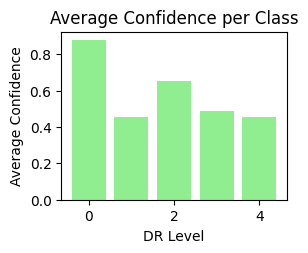

In [42]:
# 3. Top Confidence Predictions per Class
plt.subplot(2, 2, 3)
class_confidences = []
for i in range(dls.c):
    mask = (predicted_classes == i)
    if torch.any(mask):
        conf = confidence_scores[mask].mean()
        class_confidences.append(conf)
    else:
        class_confidences.append(0)
        
plt.bar(range(dls.c), class_confidences, color='lightgreen')
plt.title('Average Confidence per Class')
plt.xlabel('DR Level')
plt.ylabel('Average Confidence')

In [43]:
# 4. Prediction Timeline
plt.subplot(2, 2, 4)
plt.plot(pred_labels[:100], marker='o', linestyle='-', linewidth=1, markersize=4)
plt.title('Prediction Timeline (First 100 Images)')
plt.xlabel('Image Index')
plt.ylabel('Predicted DR Level')

plt.tight_layout()
plt.show()